# Depth of snow cover in Kaisaniemi Helsinki

This notebook investigates the depth of snow in Kaisaniemi Helsinki over last 60 years. Especially we look in to the probability of snow depth being more than 0 cm on a single day each year.



The data is originally from FMI: https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

In [1]:
# Using `suppressMessages` do disable noisy import log
suppressMessages(library(readr)) # For reading data files
suppressMessages(library(dplyr)) # de-facto library for data preprosessing
suppressMessages(library(ggplot2)) # de-facto library for visualization
suppressMessages(library(rstan))
suppressMessages(library(bayesplot))
suppressMessages(library(boot))

In [2]:
options(mc.cores = 1)
rstan_options(auto_write = TRUE)

In [3]:
# Load and cleanup data
# ovewrite original column names
# parse dates from several columns
# clean up negative snow depths
d <-  read_csv("https://raw.githubusercontent.com/dins/snow-depth/master/kaisaniemi.csv", 
               col_types = cols(`Lumensyvyys (cm)` = col_character())) %>%
      setNames(c("year", "month", "day", "clock", "tzone", "snow", "temp")) %>%
      mutate(date = ISOdate(year, month, day), 
             snow = ifelse(snow==FALSE, 0, as.numeric(snow)), 
             snow = ifelse(snow < 0, 0, snow), 
             is_snow = snow > 0) %>%
      select(date, year, month, day, snow, is_snow, temp)

In [4]:
glimpse(d)

Observations: 50,361
Variables: 7
$ date    <dttm> 1882-01-01 12:00:00, 1882-01-02 12:00:00, 1882-01-03 12:00:0…
$ year    <dbl> 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1882, 1…
$ month   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ day     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…
$ snow    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ is_snow <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ temp    <dbl> -2.6, -0.6, 1.8, 2.7, 0.4, 1.1, 2.6, -0.8, -2.3, 0.6, 1.2, -6…


In [5]:
# Look into a specific day of the year
# Remove years with out snow depth measurement
christmas <- d %>% filter(!is.na(snow))%>% filter(day==24 & month==12)

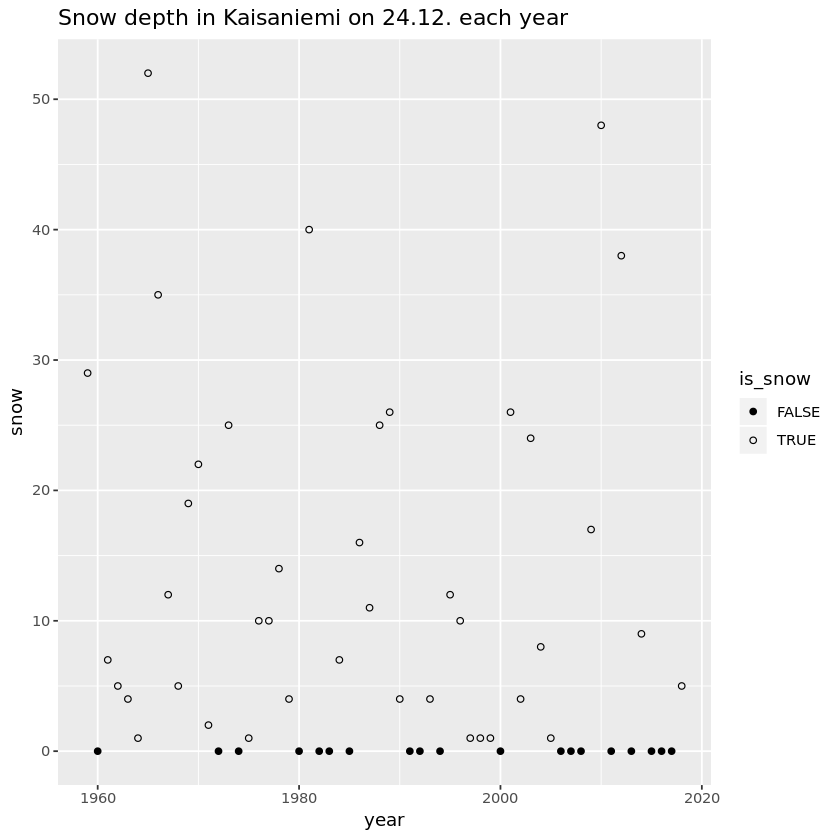

In [6]:
ggplot(christmas, aes(x=year, y=snow)) + 
  geom_point(aes(shape=is_snow)) + 
  scale_shape_manual(values=c(19, 1)) + 
  labs(title = "Snow depth in Kaisaniemi on 24.12. each year")

In [7]:
stan_data <- with(christmas, list(decade = (year-2000)/10, is_snow = is_snow, N = length(is_snow)))

In [8]:
first_model_code <- "
data {
   int N;
   int<lower=0, upper=1> is_snow[N];
}
parameters {
   real b;
}
model {
  for (i in 1:N) {
    is_snow[i] ~ bernoulli_logit(b);
  }
}
"

In [9]:
m0 <- stan_model(model_code = first_model_code)
fit0 <- sampling(m0, data = stan_data)
fit0


SAMPLING FOR MODEL 'e5a11ac8c95fc5d26bc7db44a9dc22cf' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.019633 seconds (Warm-up)
Chain 1:                0.022913 seconds (Sampling)


Inference for Stan model: e5a11ac8c95fc5d26bc7db44a9dc22cf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b      0.79    0.01 0.27   0.27   0.60   0.77   0.97   1.34  1649 1.01
lp__ -37.94    0.02 0.67 -39.82 -38.11 -37.68 -37.50 -37.46  1835 1.00

Samples were drawn using NUTS(diag_e) at Mon Dec  9 14:25:05 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

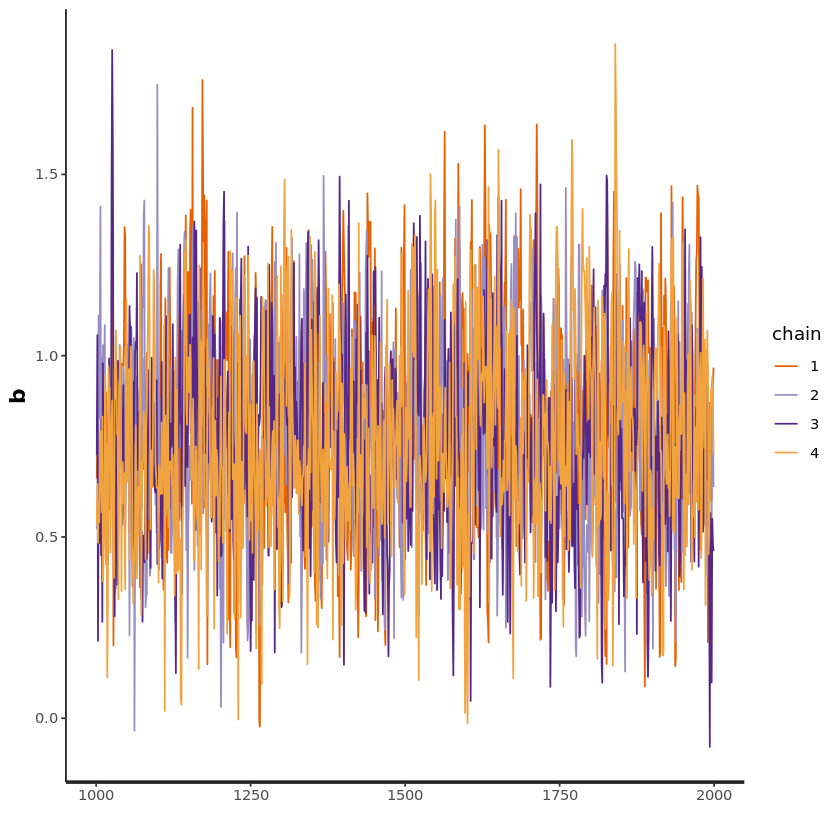

In [10]:
traceplot(fit0)

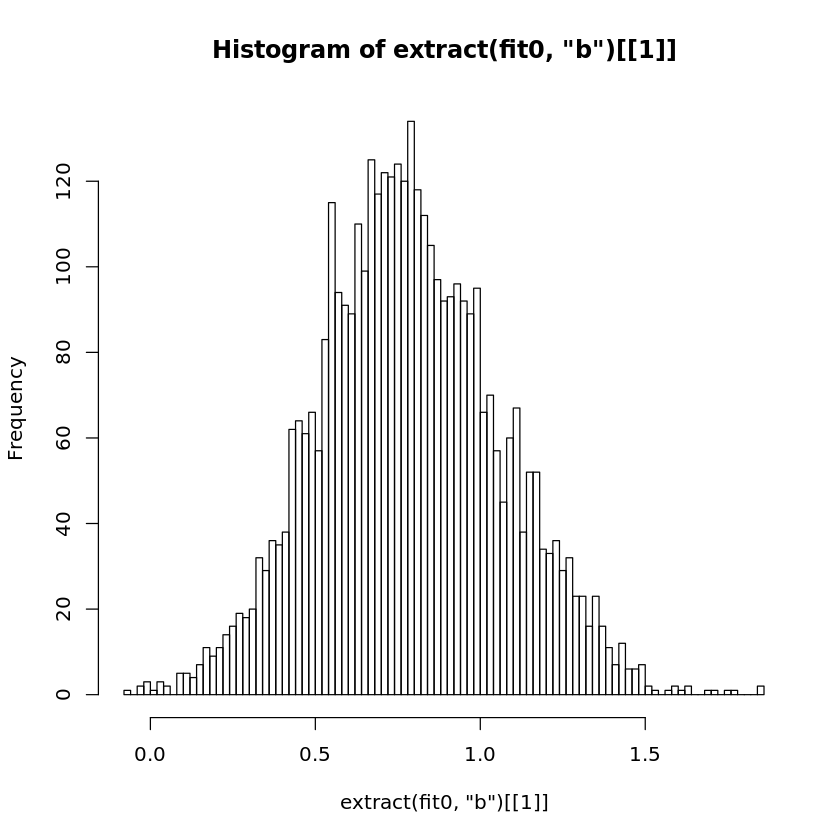

In [11]:
hist(extract(fit0, "b")[[1]], n = 100)

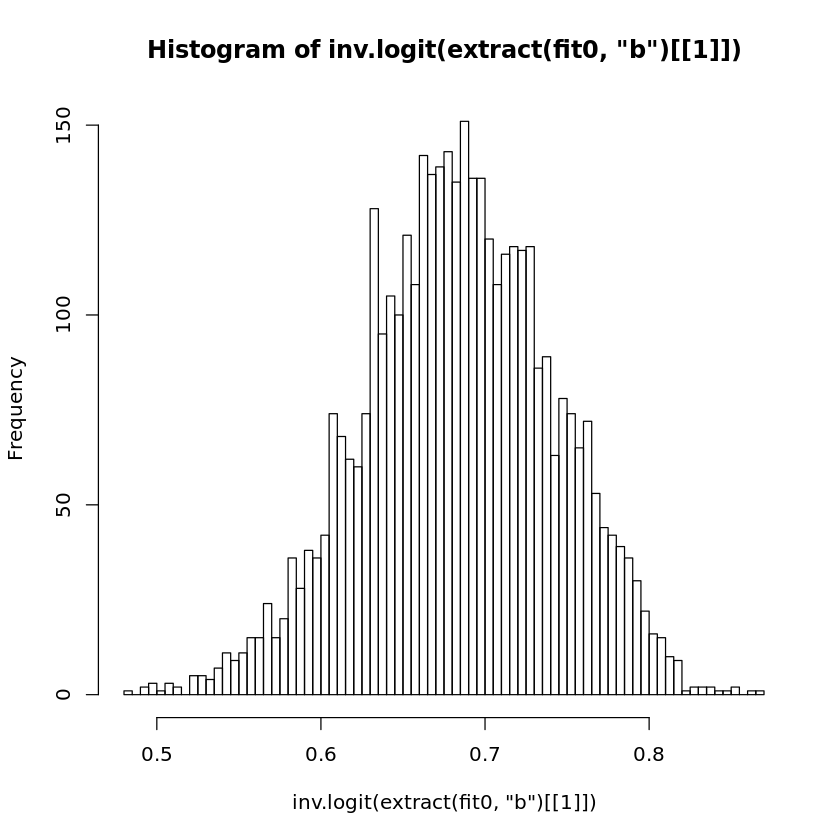

In [13]:
hist(inv.logit(extract(fit0, "b")[[1]]), n = 100)

In [14]:
second_model_code <- "
data {
  int N;
  int<lower=0, upper=1> is_snow[N];
  real decade[N]; 
}
parameters {
  real b;
  real k; 
}
model {
  for (i in 1:N) {
    is_snow[i] ~ bernoulli_logit(k * decade[i] + b);
  }
}
generated quantities {
  real prob[N];
  for (i in 1:N) {
    prob[i] = inv_logit(k* decade[i] + b);
  }
}
"

In [15]:
m <- stan_model(model_code = second_model_code)
fit <- sampling(m, data=stan_data)
fit


SAMPLING FOR MODEL 'd13e3c6b6afb41d7bd554c46bdc77c9d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.039848 seconds (Warm-up)
Chain 1:                0.042727 seconds (Sampling)


Inference for Stan model: d13e3c6b6afb41d7bd554c46bdc77c9d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b          0.47    0.01 0.33  -0.18   0.26   0.46   0.68   1.13  2151    1
k         -0.35    0.00 0.18  -0.72  -0.47  -0.35  -0.23  -0.02  1855    1
prob[1]    0.85    0.00 0.08   0.66   0.81   0.87   0.91   0.96  2591    1
prob[2]    0.85    0.00 0.08   0.66   0.81   0.87   0.91   0.96  2609    1
prob[3]    0.85    0.00 0.08   0.66   0.80   0.86   0.91   0.96  2629    1
prob[4]    0.84    0.00 0.08   0.65   0.80   0.86   0.90   0.96  2649    1
prob[5]    0.84    0.00 0.08   0.65   0.80   0.85   0.90   0.95  2671    1
prob[6]    0.84    0.00 0.08   0.65   0.79   0.85   0.89   0.95  2695    1
prob[7]    0.83    0.00 0.08   0.65   0.79   0.84   0.89   0.95  2721    1
prob[8]    0.83    0.00 0.08   0.65   0.78   0.84   0.88   0.94  2748   

'pars' not specified. Showing first 10 parameters by default.


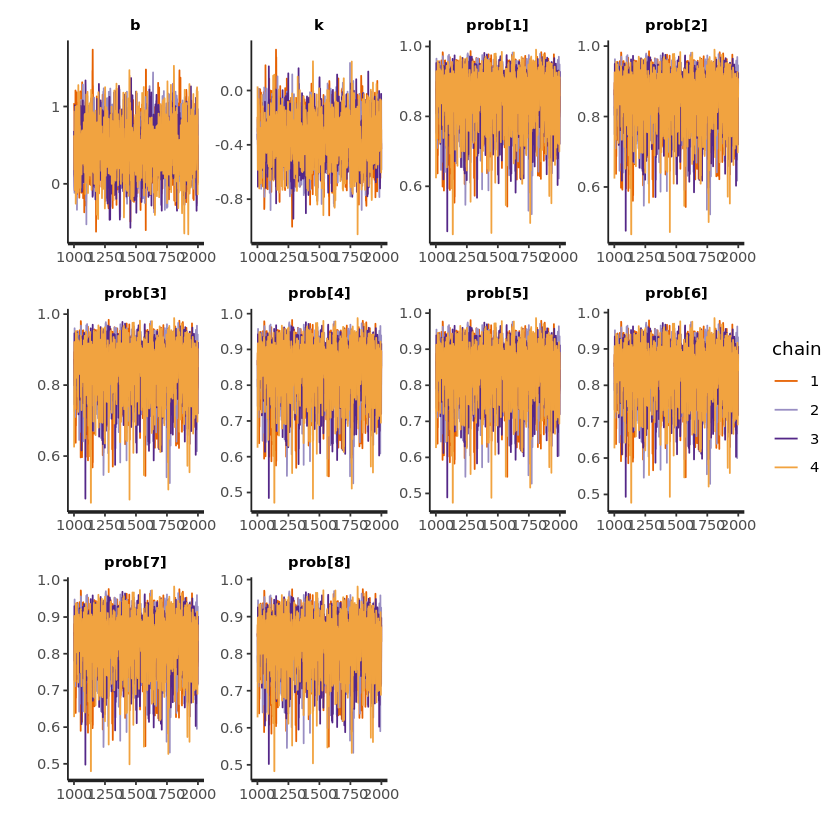

In [16]:
traceplot(fit)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


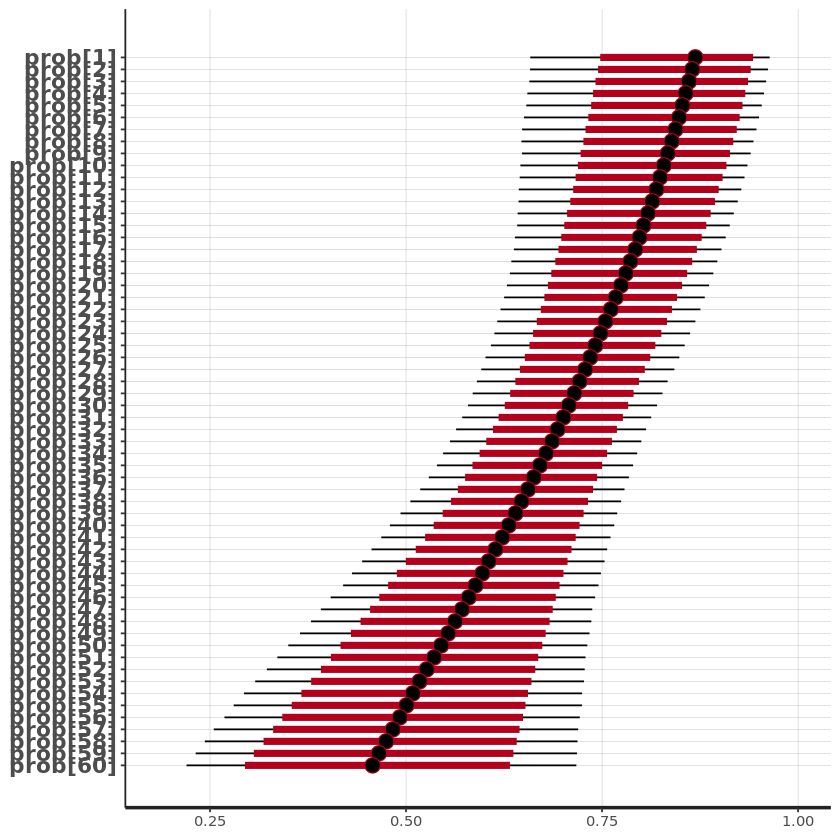

In [17]:
plot(fit, pars="prob")

In [18]:
# Has snow cover decreased significantly?
diff_samples <- extract(fit, "prob[1]")[[1]] - extract(fit, "prob[60]")[[1]]
# probability of decrease
mean(diff_samples > 0)

[1] 0.98025

In [19]:
# Now estimate snow propability for 2019
decade_2019 <- (2019 - 2000) / 10
post_draws <- extract(fit)
predictions <- inv.logit(post_draws$b + post_draws$k * decade_2019)

In [20]:
mean(predictions)

[1] 0.4528295

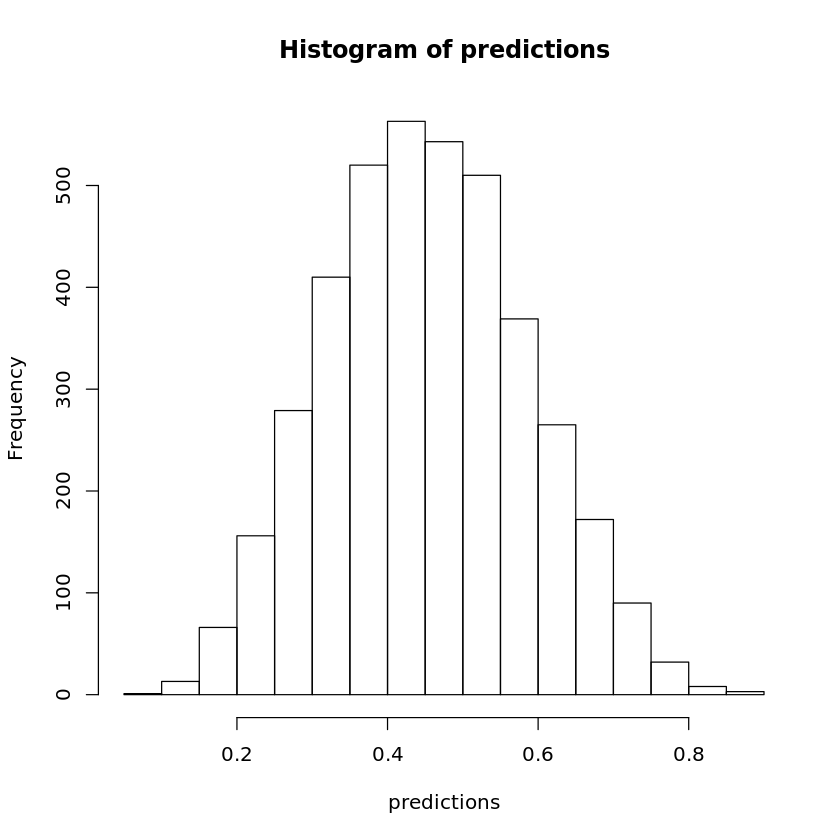

In [21]:
hist(predictions)

In [22]:
statespace_code <- "
data {
   int N;
   int<lower=0, upper=1> is_snow[N];
}
parameters {
   vector[N] innovations;
   real base;
   real<lower=0> sigma;
   real ytrend;
}
model {
   innovations ~ normal(ytrend, 1);
   is_snow ~ bernoulli_logit(base + sigma * cumulative_sum(innovations));
   base ~ normal(0, 5);
   sigma ~ normal(0, .1);
   ytrend ~ normal(0, .1);
}
generated quantities {
   vector[N] prob;
   prob = inv_logit(base + sigma * cumulative_sum(innovations));
}
"

mss <- stan_model(model_code = statespace_code)
fit_ss <- sampling(mss, data=stan_data, control=list(adapt_delta=.95))


SAMPLING FOR MODEL '51e919ab227559644dbd81e47cd8a84f' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.378421 seconds (Warm-up)
Chain 1:                0.26009 seconds (Sampling)
C

In [23]:
fit_ss

Inference for Stan model: 51e919ab227559644dbd81e47cd8a84f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
innovations[1]   -0.04    0.01 1.02  -2.09  -0.73  -0.02   0.65   1.89  9038
innovations[2]   -0.08    0.01 1.03  -2.09  -0.79  -0.06   0.62   1.93  8781
innovations[3]    0.00    0.01 0.99  -1.93  -0.69   0.00   0.68   1.95  7023
innovations[4]   -0.02    0.01 1.00  -1.98  -0.71  -0.04   0.64   1.97  9449
innovations[5]   -0.06    0.01 1.02  -2.03  -0.75  -0.07   0.64   1.97  9106
innovations[6]   -0.05    0.01 1.00  -2.04  -0.72  -0.04   0.61   1.96  7680
innovations[7]   -0.07    0.01 0.98  -1.99  -0.72  -0.09   0.60   1.87  8483
innovations[8]   -0.09    0.01 0.99  -1.98  -0.77  -0.11   0.58   1.78  9103
innovations[9]   -0.12    0.01 1.00  -2.07  -0.79  -0.11   0.54   1.89  8852
innovations[10]  -0.13    0.01 0.99  -2.10  -0.78  -

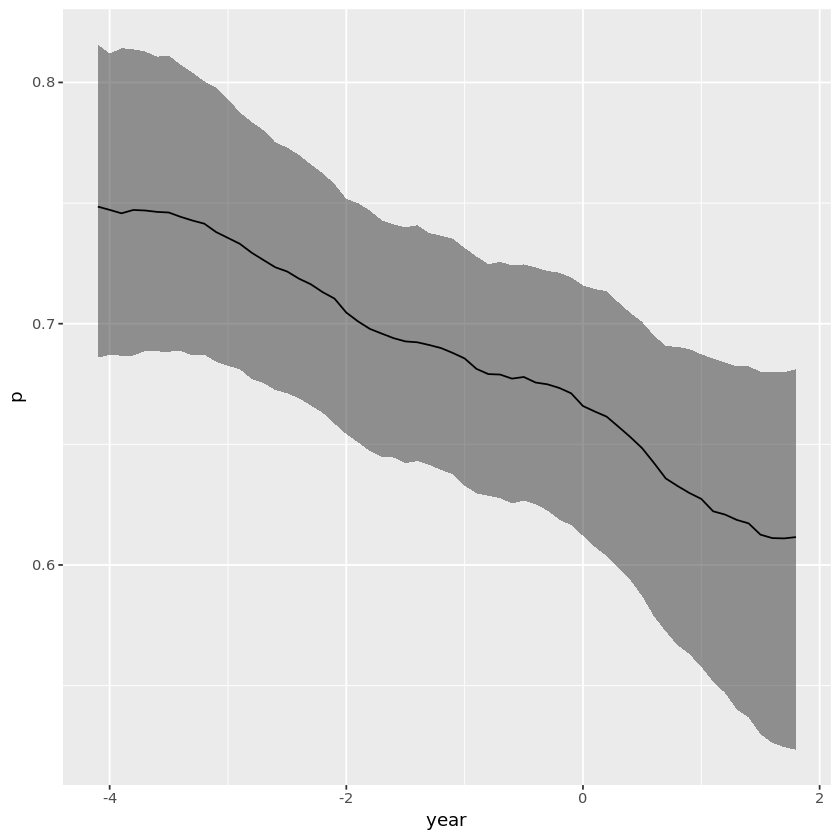

In [24]:
apply(extract(fit_ss, "prob")[[1]], 2, function (x) quantile(x, c(.25, .5, .75))) %>% 
  t() %>% 
  as.data.frame() %>%
  setNames(c("pmin", "p", "pmax")) %>% 
  mutate(year=stan_data$decade) %>%
  ggplot(aes(x=year, ymin=pmin, y=p, ymax=pmax)) +
      geom_ribbon(alpha=.5) +
      geom_line()

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


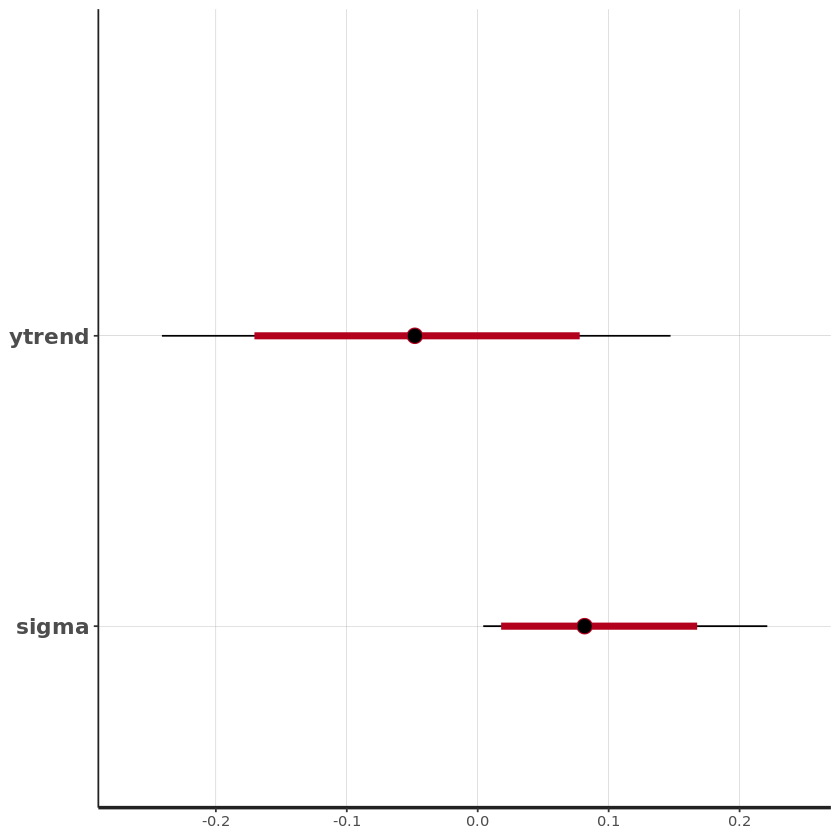

In [25]:
plot(fit_ss, pars=c("ytrend", "sigma"))

[1] 0.1615

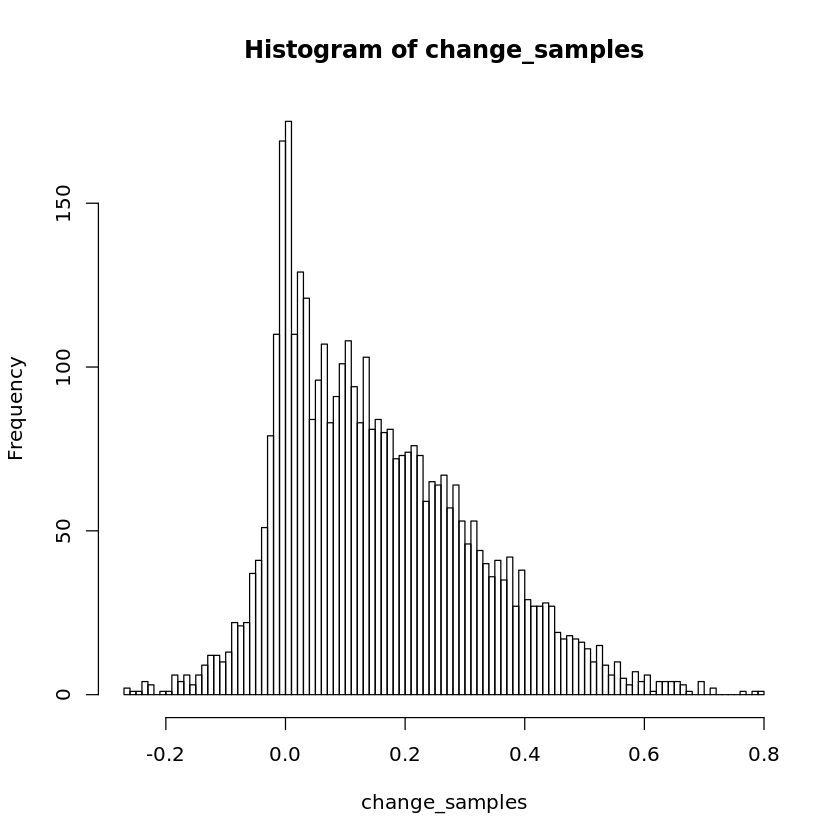

In [26]:
change_samples <- extract(fit_ss, "prob[1]")[[1]] - extract(fit_ss, "prob[60]")[[1]]
hist(change_samples, n=100)
mean(change_samples<0)